<div id="container" style="position:relative;">
<div style="float:left"><h1> Capstone Project: Diabetes risk predictor based on health indicators</h1></div>
<div style="float:left"><h2> Notebook 4: # Modelling - Created by Diego Villanueva</h2></div>
</div>
</div>

## Table of contents

4a. Modelling (Logistics Regression)

        4a.1 Load data files

        4a.2 Instantiate and fit baseline logistic regression

        4a.3 Optimising using Pipeline and Grid Search

        4a.4 Fit model with the best params

        4a.5 Model analysis

        4a.6 Model evaluation

        4a.7 x

        4a.8 x

### Imports

In [51]:
# data manipulation
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Scaling data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# PCA
from sklearn.decomposition import PCA

# File saving
import joblib 

# Temporary directories for caching
from tempfile import mkdtemp

# Cross-validation
from sklearn.model_selection import cross_val_score

# Pipeline building
from sklearn.pipeline import Pipeline

# Grid search
from sklearn.model_selection import GridSearchCV

### 4a.1 Load data files

In [2]:
X_rem_scaled = joblib.load("../data/Preprocessed_data/X_rem_oversampled_scaled.pkl") # oversampled and scaled dataset
y_rem = joblib.load("../data/Preprocessed_data/y_rem_oversampled.pkl") #oversampled dataset
X_test_scaled = joblib.load("../data/Preprocessed_data/X_test_scaled.pkl") # scaled dataset
y_test = joblib.load("../data/Preprocessed_data/y_test.pkl") #unmodified dataset

X_rem = joblib.load("../data/Preprocessed_data/X_rem_oversampled.pkl") # oversampled, not scaled dataset
X_test = joblib.load("../data/Preprocessed_data/X_test.pkl") # not scaled dataset

### 4a.2 Instantiate and fit baseline logistic regression

In [3]:
# instantiate and fit to scaled & sampled training data
log_reg = LogisticRegression(random_state=1, max_iter=150).fit(X_rem_scaled, y_rem)

In [4]:
# Check the accuracies of 
print(f'Accuracy on remainder set: {log_reg.score(X_rem_scaled, y_rem)}')
print(f'Accuracy on test set: {log_reg.score(X_test_scaled, y_test)}')

Accuracy on remainder set: 0.7701548211134285
Accuracy on test set: 0.7184247871333964


The initial model achieved an accuracy of .77 witht he remainder set and .72 with test set. The following step is to optimise the model by trying different hyperparameters and evaluators.

### 4a.3 Optimising using Pipeline and Grid Search

In [5]:
# Create a directory that will be used to cache the pipeline results
cachedir = mkdtemp()

In [6]:
# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), 
                        ('dim_reducer', PCA()), 
                        ('model', LogisticRegression())], memory=cachedir)

In [7]:
# Define range of C values to be tried
c_values = [.0001, .001, .1, 1, 10, 100, 1000]

In [8]:
# Parameter grid
log_reg_param_grid = [

    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1, max_iter=10000)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1, max_iter=10000)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1, max_iter=10000)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1, max_iter=10000)],
     'model__C': c_values}
]

In [9]:
# Instantiate the logigstic regression with grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=log_reg_param_grid, cv=5, n_jobs=-1, verbose=1)

In [10]:
# Fit the logigstic regression with grid search
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

/Users/diego/anaconda3/envs/diego_capstone/lib/python3.8/site-packages/sklearn/pipeline.py:377: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/Users/diego/anaconda3/envs/diego_capstone/lib/python3.8/site-packages/sklearn/pipeline.py:377: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 exampl

In [11]:
fitted_logreg_gs.best_estimator_

Pipeline(memory='/var/folders/6c/0s0k1hv53xn7g3bpzkggst1r0000gn/T/tmpcssim0xt',
         steps=[('scaler', StandardScaler()), ('dim_reducer', None),
                ('model',
                 LogisticRegression(C=0.001, max_iter=10000, n_jobs=-1,
                                    random_state=1))])

The best estimator used a standard scaler, no PCA, and a l2 logistic regression with a C value of 0.001 and max_iter of 10000

In [20]:
# Accuracy of the optimised model:
print("Accuracies of the optimised model:")
print(f"The best logistic regression's accuracy on the remainder set: {fitted_logreg_gs.score(X_rem, y_rem)}")
print(f"The best logistic regression's accuracy on the test set: {fitted_logreg_gs.score(X_test, y_test)}")

Accuracies of the optimised model:
The best logistic regression's accuracy on the remainder set: 0.7704222150917162
The best logistic regression's accuracy on the test set: 0.7322611163670766


We can see overfitting is present in the optiomised model

In [13]:
# Accuracy of the initial/baseline model:
print("Accuracies of the initial/baseline model:")
print(f'Accuracy on remainder set: {log_reg.score(X_rem_scaled, y_rem)}')
print(f'Accuracy on test set: {log_reg.score(X_test_scaled, y_test)}')

Accuracies of the initial/baseline model:
Accuracy on remainder set: 0.7701548211134285
Accuracy on test set: 0.7184247871333964


### 4a.4 Fit model with the best params

In [21]:
# Fit model
optimised_log_reg = LogisticRegression(C=0.001, max_iter=10000, n_jobs=-1, random_state=1).fit(X_rem, y_rem)

### 4a.5 Optimised model analysis

In [25]:
# Accuracy of the optimised model:
print("Accuracies of the optimised model:")
print(f"The best logistic regression's accuracy on the remainder set: {optimised_log_reg.score(X_rem, y_rem)}")
print(f"The best logistic regression's accuracy on the test set: {optimised_log_reg.score(X_test, y_test)}")

Accuracies of the optimised model:
The best logistic regression's accuracy on the remainder set: 0.7600172469115996
The best logistic regression's accuracy on the test set: 0.7327078734363502


In [35]:
# Get coefficients and intercept from the optimised model
coefficients = optimised_log_reg.coef_.flatten()  # Flatten the coefficients array
intercept = optimised_log_reg.intercept_

# Get names of columns 
feature_names = X_rem.columns 

# Create dataframe with features and their coefficient values
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort rows based on the coefficient value
sorted_features_df = features_df.sort_values(by='Coefficient', ascending=False)

# Display the DataFrame
print(sorted_features_df)

                   Feature  Coefficient
0              Has_high_bp     0.908569
1     Has_high_cholesterol     0.690622
2      Checked_cholesterol     0.758100
3                      BMI     0.069725
4                Is_smoker     0.049707
5               Had_stroke    -0.402475
6        Has_heart_disease     0.017405
7        Physical_activity     0.020864
8              Eats_fruits    -0.009864
9             Eats_veggies     0.199810
10           Heavy_drinker    -1.057335
11      Has_healthcare_cov     0.609326
12    No_attention_bc_cost    -0.438361
13  Mental_health_bad_days     0.000141
14      Walking_difficulty     0.137763
15                 Is_male     0.221973
16  General_health_score_2     0.007768
17  General_health_score_3     0.665908
18  General_health_score_4     0.966737
19  General_health_score_5     0.897272
20             Age_Group_2    -0.688695
21             Age_Group_3    -0.829962
22             Age_Group_4    -0.750278
23             Age_Group_5    -0.611117


In [37]:
# Get the top and bottom coefficients
low_5_coef = sorted_features_df.head(5)
high_5_coef = sorted_features_df.tail(5)

# Join them
combined_coef = pd.concat([low_5_coef, high_5_coef])

# Display results
print("Top 5 coefficients with the lowest values and top 5 with the highest values are:")
print(combined_coef)

Top 5 coefficients with the lowest values and top 5 with the highest values are:
                   Feature  Coefficient
18  General_health_score_4     0.966737
0              Has_high_bp     0.908569
19  General_health_score_5     0.897272
2      Checked_cholesterol     0.758100
1     Has_high_cholesterol     0.690622
20             Age_Group_2    -0.688695
42          Income_Group_8    -0.698317
22             Age_Group_4    -0.750278
21             Age_Group_3    -0.829962
10           Heavy_drinker    -1.057335


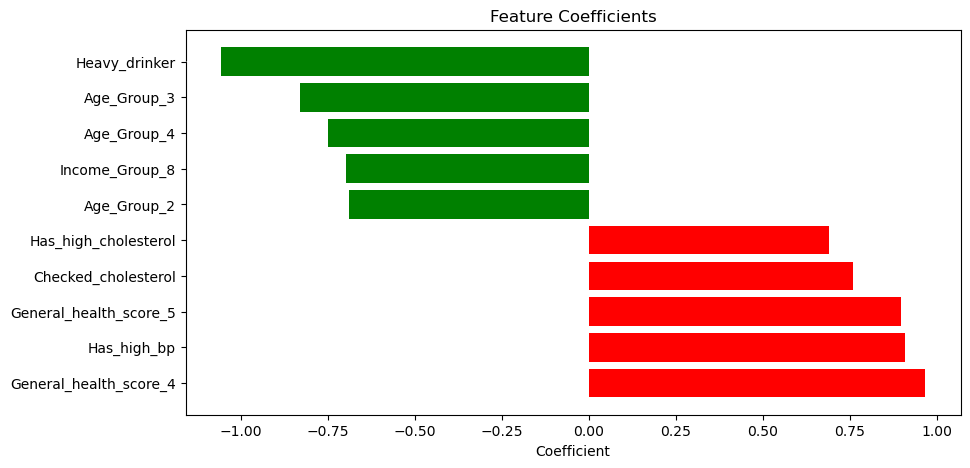

In [41]:
# Create a visualisation:
# Assign colors based on 'Coefficient' values
colors = ['green' if x < 0 else 'red' for x in combined_coef['Coefficient']]

# Create barh plot
plt.figure(figsize=(10, 5))
plt.barh(combined_coef['Feature'], combined_coef['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Feature Coefficients')

# Add the values to the bars
for index, value in enumerate(combined_coef['Coefficient']):
    if value < 0:
        plt.text(value, index, f'{value:.2f}', va='center', ha='right', color='white')
    else:
        plt.text(value, index, f'{value:.2f}', va='center', ha='left', color='white')

# Show the plot
plt.show()

### 4a.6 Model Evaluation

In [47]:
# Create confusion matrix for logistic regression

# Get class predictions
y_pred = optimised_log_reg.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative Review", "Predicted Positive Review"],
    index=["True Negative Review", "True Positive Review"]
)

display(cf_df)

,Predicted Negative Review,Predicted Positive Review
True Negative Review,47103,17008
True Positive Review,3334,8659


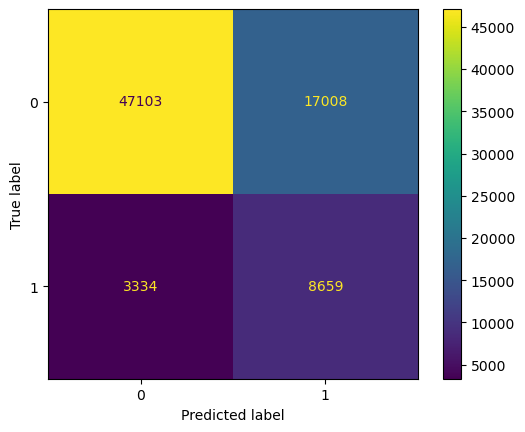

In [49]:
# Create visualisation of confusion matrix
ConfusionMatrixDisplay.from_estimator(optimised_log_reg, X_test, y_test);

In [52]:
# Classification Report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.93      0.73      0.82     64111
           1       0.34      0.72      0.46     11993

    accuracy                           0.73     76104
   macro avg       0.64      0.73      0.64     76104
weighted avg       0.84      0.73      0.77     76104

